# The PyLandstats landscape class

The [`Landscape` class](https://pylandstats.readthedocs.io/en/latest/landscape.html) of PyLandStats defines the core object upon which all the other features of the library rely on in order to compute landscape metrics over a raster landscape.

Let us start by importing the library and defining a variable with a path to a land use/land cover (LULC) raster:

In [1]:
import pylandstats as pls

lulc_filepath = '../data/raw/AS18_17.tif'

We can now initialize a `Landscape` instance as in:

In [2]:
ls = pls.Landscape(lulc_filepath)

To plot the landscape, we might use the `plot_landscape` method as in:

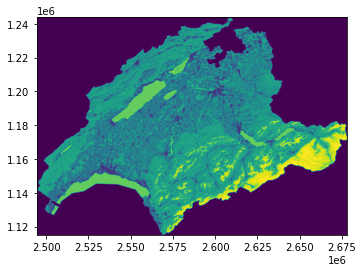

In [3]:
ls.plot_landscape()